<font face="微软雅黑" color=green size=5>pyspark机器学习</font>

In [1]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import pyspark.sql.functions as F
from pyspark.sql.functions import monotonically_increasing_id
import findspark
spark_home = "D:\\Anaconda\\Lib\\site-packages\\pyspark"
python_path = "D:\\Anaconda\\python"
findspark.init(spark_home,python_path)
spark = SparkSession.builder.appName('pysparkml').getOrCreate()

D:\Anaconda\Lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# 加载数据集

**赛题背景**  
火力发电的基本原理是：燃料在燃烧时加热水生成蒸汽，蒸汽压力推动汽轮机旋转，然后汽轮机带动发电机旋转，产生电能。 在这一系列的能量转化中，影响发电效率的核心是锅炉的燃烧效率，即燃料燃烧加热水产生高温高压蒸汽。锅炉的燃烧效率的影响因素很多，包括锅炉的可调参数，如燃烧给量，一二次风，引风，返料风，给水水量；以及锅炉的工况，比如锅炉床温、床压，炉膛温度、压力，过热器的温度等。

**赛题描述**  
经脱敏后的锅炉传感器采集的数据（采集频率是分钟级别），根据锅炉的工况，预测产生的蒸汽量。

**数据说明**
数据分成训练数据（train.txt）和测试数据（test.txt），其中字段 V0-V37，这38个字段是作为特征变量，target作为目标变量。 选手利用训练数据训练出模型，预测测试数据的目标变量，排名结果依据预测结果的 MSE（mean square error）。

In [2]:
data = spark.read.csv('../data/zhengqi_train.csv', header=True, inferSchema=True, encoding='utf-8')

In [5]:
data.printSchema() #查看数据的结构和列的数据类型

root
 |-- V0: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nullabl

# 拆分数据集

蒸汽数据集一共有38个特征属性，分别是 V0—V37，分别对应各个训练属性，有一个 target 目标属性，是预测值。

拆分数据集之前，我们将所有的训练属性合并为一个向量，然后再进行划分，这样会比较方便。

In [6]:
from pyspark.ml.feature import VectorAssembler

# 特征处理
df_assember = VectorAssembler(inputCols=data.columns[:-1], outputCol='features')
df = df_assember.transform(data)

# 划分数据集
model_df = df.select(['features', 'target'])
train_df, test_df = model_df.randomSplit([0.75, 0.25], seed=10)

# 创建模型

In [7]:
from pyspark.ml.regression import RandomForestRegressor

# 构建模型
rf = RandomForestRegressor(featuresCol='features', labelCol='target')

featuresCol指定的是训练属性。labelCol指定的是目标属性。predictionCol指定的是预测属性，在之后的模型评估中我们会用到，如果不指定 predictionCol，之后就使用默认值“prediction”。

# 模型训练

In [8]:
# 训练
rf_model = rf.fit(train_df)

# 模型保存

In [9]:
save_path = "../data/zhengqi"
rf_model.write().overwrite().save(save_path)

# 模型预测

In [10]:
# 预测
rf_prediction = rf_model.transform(test_df)

# 模型评估

In [11]:
from pyspark.ml.evaluation import RegressionEvaluator

# 创建评估器，评估器的 predictionCol 要和 模型的 predictionCol 保持一致。
evaluator = RegressionEvaluator(labelCol='target', predictionCol='prediction')
# 用 MSE 和 R2 进行评估
mse = evaluator.evaluate(rf_prediction, {evaluator.metricName: 'mse'})
r2 = evaluator.evaluate(rf_prediction, {evaluator.metricName: 'r2'})
print("MSE为:", mse)
print("R2得分：", r2)

MSE为: 0.14472338011955987
R2得分： 0.8501137022449154


# 绘制折线图

在 spark 中处理的数据都是 sql.dataframe 类型的，无法直接使用 plt 进行绘图，我们需要使用 collect 方法进行类型转换。

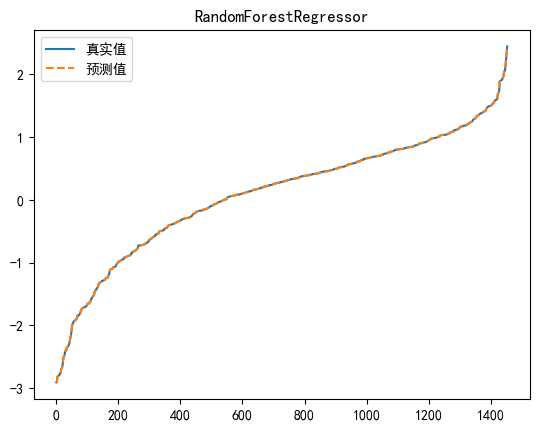

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 转换数据类型并排序
true_test = sorted(test_df.select('target').collect())
perdiction_test = sorted(rf_prediction.select('target').collect())

# 使用plt绘图
plt.figure()
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 1080
plt.rcParams['figure.dpi'] = 1080
plt.title('RandomForestRegressor')
x_label = np.linspace(1, 2*len(true_test), len(true_test))
plt.plot(x_label, true_test)
plt.plot(x_label, perdiction_test, linestyle='--')
plt.legend(['真实值', '预测值'])
# 保存图片
plt.savefig('RandomForestRegressor.png')
plt.show()

# 加载模型

In [13]:
from pyspark.ml import PipelineModel

In [ ]:
rf_model = PipelineModel.load(save_path)